In [1]:
%load_ext autoreload
%autoreload 2

# `cuML` Implementation - GPU Machine Learning Algorithms

[Source](https://github.com/rapidsai/cuml)

"cuML is a suite of libraries that implement machine learning algorithms and mathematical primitives functions that share compatible APIs with other RAPIDS projects.

cuML enables data scientists, researchers, and software engineers to run traditional tabular ML tasks on GPUs without going into the details of CUDA programming. In most cases, cuML's Python API matches the API from scikit-learn."


Why do I want to implement this? because, the normal version takes above two hourse to run. 

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

import cudf
import cupy as cp

from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from cuml.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support


from IPython.core.debugger import Pdb #Pdb().set_trace()


pd.set_option('display.max_columns', None)
path = "../data/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"id_vs_frequency_decreasing_ds.csv")
#min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

40.69% of the data decreased alpha_R
59.31% of the data did not decrease alpha_R


Class distribution can be considered is skewed.

## Treatment to Categorical Data

In [4]:
research_features = ['NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR']

TOK_characteristics = ["DIVNAME","WALMAT","DIVMAT","LIMMAT"]
categorical = ["PREMAG","HYBRID","CONFIG","ELMTYPE","ECHMODE",
               "ICSCHEME","AUXHEAT","EVAP","PELLET"] + TOK_characteristics 

DB5[categorical] = DB5[categorical].fillna('UNKNOWN')
DB5["DIVNAME"]   = DB5["DIVNAME"].str.replace("NONAME","UNKNOWN",regex=False)

DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("CC","C",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI1","TI12",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI2","TI12",regex=False)

DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-I)|(DV-IPRE)|(DV-IPOST)",
                                            "DV-I",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-II)|(DV-IIc)|(DV-II-C)|(DV-IIb)|(DV-IIc)|(DV-IId)|(DV-IId)",
                                            "DV-II",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(MARK0)|(MARKI)|(MARKIIA)|(MARKGB)|(MARKGBSR)|"+
                                            "(MARKIA)|(MARKIAP)|(MARKSR)|(MARKA)|(MARKP)",
                                            "MARK",regex=True)

DB5["ICSCHEME"]   = DB5["ICSCHEME"].str.replace("OFF","NONE",regex=False)

# Removing noise on heating scheme | the removed coluns are shots from 1996
DB5 = DB5[~DB5["AUXHEAT"].isin(["UNKNOWN"])]

DB5["EVAP"] = DB5["EVAP"].str.replace("CARBH","C-H",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("CARB","C",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("BOROC","C-BO",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("(BOROA)|(BOROB)|(BOROX)|(BOR)","BO",regex=True)

DB5["PELLET"] = DB5["PELLET"].str.replace("GP_D","D",regex=False)
DB5["PELLET"] = DB5["PELLET"].str.replace("GP_H","H",regex=False)

## Treatment to Numerical Data | `DB5`

In [5]:
plasma_characteristics = ["QCYL5","BEIMHD","PREMAG","LHTIME","HYBRID",
                          "CONFIG","DWDIA","WMHD","TORQ"
                         ] 
TOK_characteristics = ["TOK","DIVNAME","WALMAT","DIVMAT","LIMMAT"]
ELM = ["ELMTYPE","ELMFREQ"]
heating = ["PECRH", "PICRH", "ICSCHEME","AUXHEAT"]
impurities = ["EVAP","ZEFF","ZEFFNEO","PRAD","POHM","ENBI"]
 # corrections on power loss | NBI Power lost by unconfined orbits
power = ["PLTH","PFLOSS"]
temperatures = ["TAV","TEV","TIV"]
# e-density in SOL | total due to NBI| total due to ICRH
fast_particles = ["NESOL","WFFORM","WFICFORM"] 
research_features = ['NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR']

interesting_features = set(plasma_characteristics + TOK_characteristics + ELM + heating + \
                       impurities + power  + fast_particles)

data_ = DB5.copy()
data_ = data_[list(interesting_features)]

num_features = data_.select_dtypes(include=['int', 'float']).columns.tolist()

This is what I had before to join comlumns.

```Python
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[num_features] ), columns = num_features)
data = pd.concat([DB5_,DB5[categorical]], axis=1, join="inner")
```

In [6]:
data = DB5.copy()
data = data[num_features + categorical + ["label","TOK"]]

### Treatment to Numerical Data and One Hot Encoding | `data`

In [7]:
def impute_with_median(series):
    return series.fillna(series.median())

for tokamak in data["TOK"].unique():
    indx_tok = data[data['TOK'] == tokamak].index
    data.loc[indx_tok, num_features] = data[num_features].apply(impute_with_median)

data[num_features] = StandardScaler().fit_transform(data[num_features])

encoder = OneHotEncoder()
transformed = encoder.fit_transform(data[categorical])
ohe_df = pd.DataFrame(transformed.toarray(),
                     columns=encoder.get_feature_names_out(categorical)
                     )
data_ = pd.concat([data[num_features + ["label"]], ohe_df], axis=1)

In [8]:
X = cudf.DataFrame(data_.drop("label", axis=1))
y = cudf.Series(data_["label"])

# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

# Convert cuDF dataframes to cuPy arrays
X_train_cupy = X_train.astype('float32').to_cupy().get()
y_train_cupy = y_train.astype('float32').to_cupy().get()

In [9]:
# Define the hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [90, 100, 110],
    'max_depth': [20, 25, 30],
    'min_samples_split': [1, 2],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None],
#    'criterion': ['gini', 'entropy'] not supported in cuML
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, 
                           param_grid, 
                           cv= 5, #StratifiedKFold(n_splits=10, shuffle=True, random_state=71), 
                           scoring='recall', 
                           n_jobs=1, 
                           refit=True
                          )
# Fit the GridSearchCV object to your training data
grid_search.fit(X_train_cupy, y_train_cupy)


# Takes less than 10 min to run

/home/chinas/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
810 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/home/chinas/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/chinas/miniconda3/envs/thesis/lib/python3.10/contextlib.py", line 79, in inner
    return func(*args, **kwds)
  File "/home/chinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py", line 188, in wrapper
    ret = func(*args, **kwargs)
  File "r

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'max_depth': [20, 25, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [1, 2, 3, 4],
                         'n_estimators': [90, 100, 110]},
             scoring='recall')

In [10]:
# Get the best hyperparameters and best model from the GridSearchCV
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model on the entire training set
best_model.fit(X_train_cupy, y_train_cupy)

# Make predictions on the test set
y_pred = best_model.predict_proba(X_val)

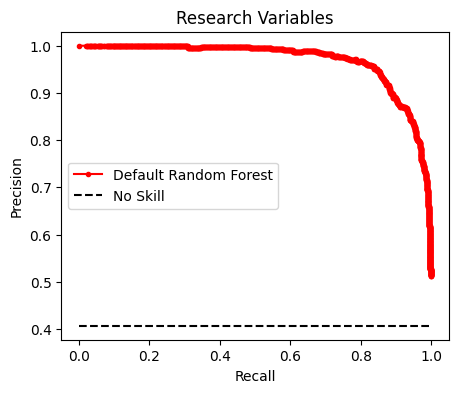

In [11]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot(recall, precision, marker='.', label='Default Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Research Variables")
plt.legend();

In [12]:
y_pred_ = best_model.predict(X_val)
precision_recall_fscore_support(y_val.to_numpy(), y_pred_.to_numpy(), labels=[1,0])

(array([0.92947814, 0.91080617]),
 array([0.86369594, 0.95503597]),
 array([0.89538043, 0.93239684]),
 array([ 763, 1112]))

In [13]:
best_params

{'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}